# Develop MOF dreaming workflow

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# imports
import sys, os
sys.path.append('../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from plot_utils import save_parity_plot, prediction_loss, create_parity_plot
from nn_functions import featurize_df, split_dataframe, prepare_hybrid_dataset, MolecularLSTMModel, validate
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
import torch
import torch.optim as optim
from torch import nn
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)


### Collect our training data

In [2]:
training_data = pd.read_csv('training_data.csv')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [3]:
group_grammar = GroupGrammar.from_file('gs_mof_grammar.txt')

In [ ]:
target_names = ["cp"]

# Here we featurise the MOFs (i.e. create the tokenized representation of the MOF strings based on their node, edge and topology representations)
mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

train_samples = 10000
split_by = {
    'method': 'sample',
    'train': train_samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

# Load Language Models

In [5]:
# Model parameters
num_tokens_first_part = len(tokenized_info['alphabet'])
num_tokens_second_part = len(tokenized_info['node_plus_topo_alphabet'])
embedding_dim_second_part = 10
hidden_dim = 50
output_dim = len(target_names)  # number of target variables
num_layers=1,
dropout_prob=0.1
hyperparams = {'num_tokens_first_part': num_tokens_first_part,
                'num_tokens_second_part': num_tokens_second_part,
                'embedding_dim_second_part': embedding_dim_second_part,
                'hidden_dim': hidden_dim,
                'output_dim': output_dim,
                'num_layers': num_layers,
                'dropout_prob': dropout_prob
                }

hybrid_model = MolecularLSTMModel(num_tokens_first_part,num_tokens_second_part, embedding_dim_second_part, hidden_dim, output_dim)
hybrid_model.initialize_weights()  

## Model training

Here we implement the main training loop with incremental noise injection on the zero-elements of the one-hot encoded linker representations. After each model is trained at different increments of noise, these weights are used at the next noise interval to help the model learn the underlying input-output relationship under variable degrees of noise. 

In [ ]:
total_noise_levels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6]
for total_noise in total_noise_levels:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = hybrid_model
    model.to(device)
    model.train()  # Put the model in training mode
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%% HYBRID MODEL TRAINING %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Loss function
    criterion = nn.MSELoss()

    # Optimizer (you can adjust the learning rate and other parameters as needed)
    lr = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Number of epochs
    num_epochs = 200
    mse_losses, mae_losses = [], []
    train_mae_losses = []                # training losses
    best_loss = float('inf')
    patience = 10
    no_improvement_counter = 0
    state_dicts = []

    # Training Loop
    injection_interval = 15
    model_name = f'LSTM_interval_noise_with_weights_{str(total_noise)[0]+str(total_noise)[-1]}_{target_names[0]}_{train_samples}samples_group_selfies'

    noise_levels = np.linspace(0,total_noise,injection_interval)
    
    _, scaler = prepare_hybrid_dataset(train_df,tokenized_info,target_names,pad_node=False ,batch_size=1, shuffle=True, train=True, noise_level=None)
    validate_loader, _ = prepare_hybrid_dataset(validate_df,tokenized_info,target_names,pad_node=False,batch_size=1, shuffle=True, train=False,scaler=scaler,noise_level=noise_levels[-1])
    test_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_names,pad_node=False,batch_size=1, shuffle=True, train=False,scaler=scaler,noise_level=noise_levels[-1])

    for epoch in range(num_epochs):
        noise_level = noise_levels[min(epoch,injection_interval-1)]
        train_loader, scaler = prepare_hybrid_dataset(train_df,tokenized_info,target_names,pad_node=False ,batch_size=1, shuffle=True, train=True, noise_level=noise_level)
        total_mae = 0

        for i, (onehot_input, embedding_input, target_values) in enumerate(train_loader):
            
            # prepare data (if embedding_input == List, then it is not padded, therefore convert to tensor for batch size = 1 processing)
            if type(embedding_input) == list:
                embedding_input = torch.stack(embedding_input, dim=0).squeeze().unsqueeze(0)    
            onehot_input, embedding_input, target_values = onehot_input.to(device), embedding_input.to(device), target_values.to(device)

            # backpropogation
            optimizer.zero_grad()
            outputs = model(onehot_input, embedding_input)
            loss = criterion(outputs, target_values)
            loss.backward()
            optimizer.step()
            total_mae += torch.abs(outputs - target_values).sum().item()
        train_mae_losses.append((total_mae / len(train_loader.dataset)))

        # Validation only after first N epochs for noise injection
        if epoch > injection_interval-1:
            mse_loss, mae_loss = validate(model, validate_loader, criterion)
            print(f'epoch: {epoch}, mse loss: {mse_loss:.4f}, mae loss: {mae_loss:.4f}')

            mse_losses.append(mse_loss)
            mae_losses.append(mae_loss)
            # if not os.path.exists('./learning_curves/'):
            #     os.makedirs('./learning_curves/')
            # prediction_loss(train_mae_losses,epoch,filename=f'./learning_curves/{model_name}_train_losses.png',test_losses=mae_losses,injection_interval=injection_interval)

            if mae_loss < best_loss:
                best_loss = mae_loss
                print(f"New best loss: {best_loss:.4f} at epoch {epoch}")
                best_state_dict = model.state_dict()
                best_state_dict_cpu = {k: v.to('cpu') for k, v in best_state_dict.items()}
                train_info = {'model_state_dict': best_state_dict_cpu,
                            'validate_loss': best_loss,
                            'learning_rate':lr,
                            'scaler': scaler,
                            'tokenized_info': tokenized_info,
                            'noise_level': noise_level,
                            'target_name': target_names,
                            'hyperparams': hyperparams
                            }
            
                # if not os.path.exists('./parity_plots/'):
                #     os.makedirs('./parity_plots/')
                # save_parity_plot(model, scaler, validate_loader, f'./parity_plots/{model_name}.png')
    
                with open('./mof_saved_models/{}.pkl'.format(model_name), 'wb') as f:
                    pickle.dump(train_info, f)
                no_improvement_counter = 0
    
            else:
                no_improvement_counter += 1
                if no_improvement_counter >= patience:
                    print(f"Early stopping triggered. No improvement in MSE loss for {patience} epochs.")
                    break
        else:
            print(f'epoch: {epoch}')
            # if not os.path.exists('./learning_curves/'):
            #     os.makedirs('./learning_curves/')
            # prediction_loss(train_mae_losses,epoch,filename=f'./learning_curves/{model_name}_train_losses.png')


    print('Finished Training')


## Test model

In [36]:
target_names = ['cp']

dream_name = f'LSTM_interval_noise_06_{target_names[0]}_11000samples_group_selfies'
with open('./mof_saved_models/{}.pkl'.format(dream_name), 'rb') as f:
    dream_train_info = pickle.load(f)
scaler = dream_train_info['scaler']
tokenized_info = dream_train_info['tokenized_info']
dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
dream_hyperparams = dream_train_info['hyperparams']

predictor_name = f'LSTM_interval_noise_00_{target_names[0]}_11000samples_group_selfies'
with open('./mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

dreaming_model = MolecularLSTMModel(**dream_hyperparams)
dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

(1000, 1)


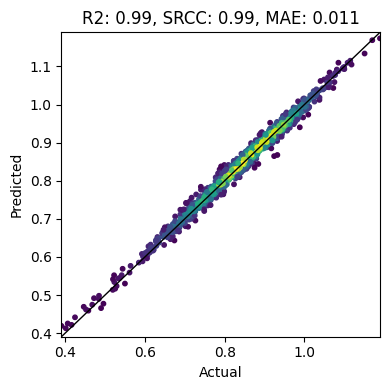

In [37]:
validate_loader, _ = prepare_hybrid_dataset(validate_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=predictor_scaler,noise_level=predictor_train_info['noise_level'])
create_parity_plot(predictor_model, predictor_scaler, validate_loader)

(1000, 1)


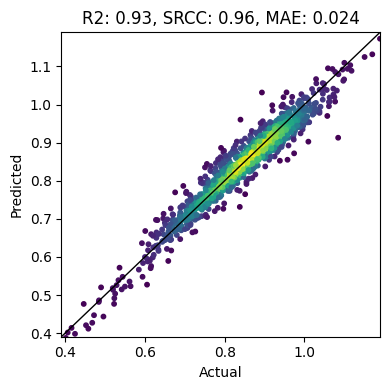

In [38]:
validate_loader, _ = prepare_hybrid_dataset(validate_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=scaler,noise_level=dream_train_info['noise_level'])
create_parity_plot(dreaming_model, predictor_scaler, validate_loader)